In [1]:
# Install library for reading JPK File
%pip uninstall pyafmreader --yes
%pip install git+https://github.com/jlopezalo/pyafmreader.git

Found existing installation: pyafmreader x.x.x
Uninstalling pyafmreader-x.x.x:
  Successfully uninstalled pyafmreader-x.x.x
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmreader.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-1prcbkqs
  Running command git clone -q https://github.com/jlopezalo/pyafmreader.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-1prcbkqs
  Cloning https://github.com/TkTech/fasterzip.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-install-afh46ujx/fasterzip_a9bcbb03c93a4e4eb5d1fd58355e677f
  Running command git clone -q https://github.com/TkTech/fasterzip.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-install-afh46ujx/fasterzip_a9bcbb03c93a4e4eb5d1fd58355e677f
  Created wheel for pyafmreader: filename=pyafmreader-x.x.x-py3-none-any.whl size=22804 sha256=acff3cef7b130b7a9a7c17fcb9e187b4157259cffcc7fb098b33ab9

In [2]:
# Install library for AFM data Rheology Analysis
%pip uninstall pyafmrheo --yes
%pip install git+https://github.com/jlopezalo/pyafmrheo.git

Found existing installation: pyafmrheo 0.0.1
Uninstalling pyafmrheo-0.0.1:
  Successfully uninstalled pyafmrheo-0.0.1
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmrheo.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-op0b6j13
  Running command git clone -q https://github.com/jlopezalo/pyafmrheo.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-op0b6j13
  Created wheel for pyafmrheo: filename=pyafmrheo-0.0.1-py3-none-any.whl size=26132 sha256=cee9b2daca4c2cadcb4ca88307a244ac15a03a67262762fbd43bab3af57ad329
  Stored in directory: /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-ephem-wheel-cache-td02npxn/wheels/fb/66/18/3e93b45c845b0d7b83ded1e127a1c127820d070ce5b71dece4
Successfully built pyafmrheo
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import libraries we will need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import detrend

# Get file reader from library
from pyafmreader import loadfile

# Get data analysis tools
from pyafmrheo.utils.force_curves import *
from pyafmrheo.models.hertz import HertzModel

In [4]:
# Define global variables
file_path = '/Users/javierlopez/Documents/Marseille/05-11-2021/E/map-data-2021.11.05-15.41.45.699.jpk-force-map'
# Shapes available: paraboloid, pyramid
indenter_shape = "pyramid"
# tip_parameter = 500 * 1e-9 # meters
tip_parameter = 35 # degrees
# Poisson ratio
poisson_ratio = 0.5
# If None it will use the deflection sensitivity from the file
deflection_sensitivity = None # m/V
# If None it will use the spring constant from the file
spring_constant = None # N/m
# General plotting params
plt.rcParams["figure.figsize"] = (10,5)

In [5]:
file = loadfile(file_path)

In [6]:
filemetadata = file.filemetadata

In [7]:
closed_loop = filemetadata['z_closed_loop_status']
file_deflection_sensitivity = filemetadata['original_deflection_sensitivity'] #nm/V
file_spring_constant = filemetadata['original_spring_constant'] #N/m
height_channel = filemetadata['height_channel_key']

if not deflection_sensitivity: deflection_sensitivity = file_deflection_sensitivity / 1e9 #m/V
if not spring_constant: spring_constant = file_spring_constant

In [10]:
curve_idx = 0
force_curve = file.getcurve(0)
extend_segments = force_curve.extend_segments
pause_segments = force_curve.pause_segments
modulation_segments = force_curve.modulation_segments
retract_segments = force_curve.retract_segments
force_curve_segments = force_curve.get_segments()

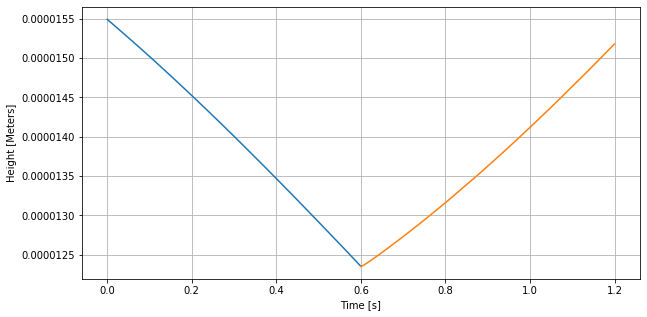

In [11]:
t0 = 0
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, height)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Height [Meters]")
plt.grid()
plt.show()

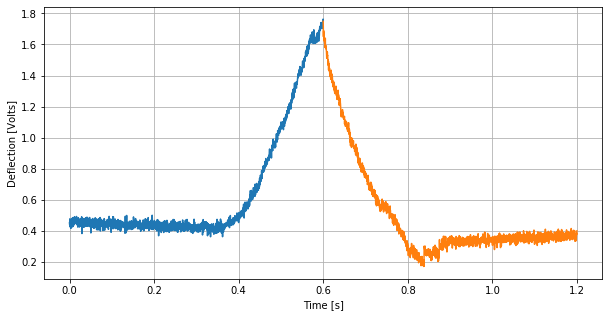

In [12]:
t0 = 0
for seg_id, segment in force_curve_segments:
    deflection = segment.segment_formated_data["vDeflection"]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, deflection)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Deflection [Volts]")
plt.grid()
plt.show()

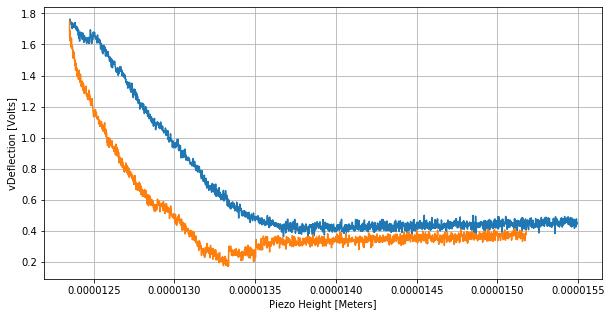

In [13]:
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    deflection = segment.segment_formated_data["vDeflection"]
    plt.plot(height, deflection)

plt.xlabel("Piezo Height [Meters]")
plt.ylabel("vDeflection [Volts]")
plt.grid()
plt.show()

In [18]:
# Get approach, first extend segment
first_exted_seg_id, first_ext_seg = extend_segments[0]
first_ext_seg.preprocess_segment(deflection_sensitivity, height_channel)

app_height = first_ext_seg.zheight
app_deflection = first_ext_seg.vdeflection

# Get retract, last retract segment
last_ret_seg_id, last_ret_seg = retract_segments[-1]
last_ret_seg.preprocess_segment(deflection_sensitivity, height_channel)

ret_height = last_ret_seg.zheight
ret_deflection = last_ret_seg.vdeflection

In [20]:
# Shift height
xzero = ret_height[-1] # Maximum height
app_height = xzero - app_height
ret_height = xzero - ret_height

In [21]:
# Find initial PoC, you may get some warnings.
poc = get_poc_RoV_method(app_height, app_deflection, win_size=60)
print(*poc)

1.5863563987854109e-06 1.375145042506078e-09


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


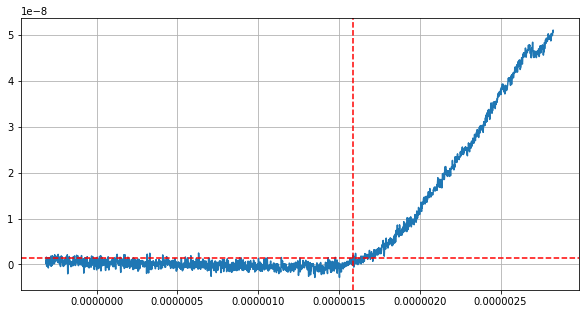

In [22]:
plt.plot(app_height, app_deflection)
plt.axvline(x=poc[0], color='r', linestyle='--')
plt.axhline(y=poc[1], color='r', linestyle='--')
plt.grid()
plt.show()

In [26]:
# Hertz fit
poc[1] = 0
first_ext_seg.get_force_vs_indentation(poc, spring_constant)
app_indentation, app_force = first_ext_seg.indentation, first_ext_seg.force

hertzmodel = HertzModel(indenter_shape, tip_parameter)

hertzmodel.fit(app_indentation, app_force)

hertz_E = hertzmodel.E0
hertz_d0 = hertzmodel.delta0

print(hertz_result.fit_report())

# Plot Hertz Fit results
plt.plot(app_indentation-hertz_d0, app_force, label="Experimental Data")
plt.plot(app_indentation-hertz_d0, hertz_result.best_fit, label="Model Fit")
plt.xlabel('Indentation [m]')
plt.ylabel('Force [N]')
plt.legend()
plt.grid()
plt.show()

ValueError: `sigma` has incorrect shape.